## STAT323 Party!
- 오늘은 2018-1 최태련 교수님의 통계계산방법의 과제들을 풀어보는 시간입니다.
- 다만 python으로 말이죠!

### 1. Standard normal distribution
함수 $f(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^{2}}$에 대하여, 0 근방에서의 Taylor 급수를 $f(x) = \sum^{\infty}_{n=0}a_{n}x^{n}$이라고 하면, $F(x)=\int^{x}_{0}f(t)dt$는 다음과 같이 표현된다.  
$$F(x)=\int^{x}_{0}f(t)dt=\sum^{\infty}_{n=0}a_{n}\frac{x^{n+1}}{n+1}$$

#### a)
F(x)를 계산하는 사용자 정의 함수를 Python으로 구현하고 F(1)을 계산하시오. 아울러, Python의 내장 함수(예, scipy.stats.norm.cdf())를 이용하여 계산한 F(1)의 값과 사용자 정의 함수를 이용하여 계산한 F(1)과 비교하시오.  

* define log factorial function with sterling approximation : log_factorial
    - Sterling approximation : https://bit.ly/2yHEY0U
    - but we use lgamma function
    - R document에 따르며 R의 lfactorial은 lgamma로 부터 나왔다.

In [1]:
# import math, numpy, pandas, scipy, matplotlib.pyplot package
import math
import numpy as np
import pandas as pd
import scipy.stat
import matplotlib.pyplot as plt

# print math.gamma(6)
print(math.gamma(6))

# print math.lgamma(6)
print(math.lgamma(6))

# print math.exp(math.lgamma(6))
print(math.exp(math.lgamma(6)))

120.0
4.787491742782047
120.00000000000009


In [2]:
def log_factorial(n):
    if n < 0:
        raise ValueError
    else :
        fn = math.lgamma(n+1)
    return fn

In [3]:
# print log factorial of 3
print(log_factorial(3))

# print exp(log factorial of 3) with math.exp. Please round!
print(math.exp(log_factorial(3)))

# print 3 factorial with math.factorial
print(math.factorial(3))

1.7917594692280554
6.000000000000003
6


* define standard normal distribution (CDF) with Taylor expansion. : stn_cdf()
* _HINT : standard normal distribution을 0 근방에서의 Taylor 급수를 구해보세요._
    - _HINT : $e^{x}$의 Taylor expansion을 활용해보세요._

In [4]:
def stn_cdf(x, eps = 1e-15, max_iter = 100) :
    def temp(x, n) :
        numerator = ((-1)**n)*(x**(2*n+1))
        denominator = math.sqrt(2*math.pi)*math.exp(log_factorial(n))*(2**n)*(2*n+1)
        return numerator/denominator

    n = 0
    sums = 0.5
    while abs(temp(x,n)) > eps :
        sums += temp(x,n)
        n += 1
        if n == max_iter : break
    return sums

In [5]:
# print scipy.stats.norm.cdf(1)
print(scipy.stats.norm.cdf(1))

# print stn_cdf(1)
print(stn_cdf(1))

0.8413447460685429
0.8413447460685431


* 추신 : 스털링 근사를 소개하였지만, 생각보다 오차가 커서 문제에 포함되지 않았습니다.

--------------
#### b)
Python의 numpy.random.normal() 함수를 사용하여, 표준정규분포를 따르는 확률변수 2000개를 생성하고, 이 중 0보다 큰 값을 변수 y에 저장한 후, F(y)값을 갖는 새로운 변수 u를 생성하시오. 이 때, u 에 저장된 값들이 0과 1사이에서의 균등분포를 따르는지 카이제곱 적합도 검정을 통해서 확인하시오.


* 문제에서 원하는 u변수를 만들어봅시다.

In [6]:
# set random seed : 1111
np.random.seed(1111)

# generate 2000 random variables
y1 = np.random.normal(0, 1, size = 2000)

# generate y
y = y1[y1 > 0]

# generate u with stn_cdf()
u = np.array([stn_cdf(x) for x in y])

# print length of u
print(len(u))

1023


* 카이제곱 적합도 검정을 실시해봅시다.  
$$\chi^{2}(=\sum \frac{(obs-E)^{2}}{E})$$
    - obs : 각 구간에서 관측된 값의 갯수  
    - E : Unifrom(0,1)을 따른다고 가정했을 때, 각 구간에서 관측될 것이라 예상하는 관측치의 갯수

* 카이제곱 적합도 검정을 하는 함수를 만들어봅시다.
    - 이 함수는 해당 array가 Uniform(u1,u2)를 따르는지 확인해줄겁니다.

In [7]:
def chisq_test_unif(array, u1 = 0, u2 = 1, interval = 10, output=True):
    obs = []
    check = (u2-u1)/interval
    for i in range(interval):
        obs.append(len(array[(i*check + u1 <= array) &\
                             (array < (i+1)*check + u1)]))
    e = np.array([len(array)/interval]*interval)
    
    chi_square = sum((obs-e)**2/e)
    p_value = scipy.stats.chi2.sf(chi_square, interval-1)
    
    if output == True:
        print('Chi square score : {}\np_value : {}'\
              .format(round(chi_square, 4), p_value))
    return chi_square, p_value

In [8]:
# u가 Uniform(0, 1)을 따르는지 확인하시오.
chisq_test_unif(u, 0, 1, 10)

Chi square score : 1027.0782
p_value : 2.4953393201707536e-215


(1027.0782013685239, 2.4953393201707536e-215)

0에서 1까지의 구간을 총 10개의 구간으로 나누면 각 구간의 기대도수(e)는 0.1*len(u)가 된다.  
위에서 구한 chi_square를 토대로 카이제곱 적합도 검정의 p-value를 구하면 0에 근사한 값이 나오므로 귀무가설을 기각할 수 있다.  
귀무가설은 u가 Uniform(0, 1)를 따른다이므로, 검정 결과 u는 Uniform(0,1)를 따르지 않음을 알 수 있다.

* Bootstrap으로 카이제곱 통계량들을 구하시오.
    - 이를 이용하여 95% CI를 구하시오 : chisqCI_95

In [9]:
chi_squares = []
for _ in range(10000):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.unique(np.random.choice(u, size=len(u)))
    chi_squares.append(chisq_test_unif(bs_sample, 0, 1, 10, False)[0])

chisqCI_95 = np.percentile(chi_squares, [2.5, 97.5])

신뢰구간에 u의 카이제곱 통계량이 들어가지 않는다.

* Bootstrap을 활용하여 p-value를 구하시오.

In [10]:
chisq = chisq_test_unif(u, 0, 1, 10, False)[0]
p_value = sum(np.array(chi_squares) >= chisq)/len(chi_squares)
print('Chi square score : {}\np_value : {}'\
              .format(round(chisq, 4), p_value))

Chi square score : 1027.0782
p_value : 0.0


실제 p-value도 0에 가깝기에 Bootstrap을 이용한 p-value가 0이 나온다.

-------------------
#### c)
u에 저장된 값들이 0과 1사이에서의 균등분포를 따르지 않는다고 결론을 내린다면, Uniform(1/2,1) 을 따르는지 확인하시오. 아울러, Uniform(1/2,1)을 따르는 1000개의 난수값을 사용자 정의 함수를 통해 생성하고, 생성된 1000개의 값이 서로 독립인지 시각적 방법으로 확인하시오.


* u가 Uniform(0.5, 1)을 따르는지 카이제곱 검정을 통해서 확인하시오.

In [11]:
chisq_test_unif(u, 0.5, 1, 10)

Chi square score : 8.2317
p_value : 0.5109785934032254


(8.2316715542522, 0.5109785934032254)

p-value가 0.05보다 커서 유의수준 0.05하에서 귀무가설을 기각하지 못한다. 즉, u는 Uniform(0.5, 1)을 따른다.

* Uniform(0.5, 1)을 따르는 1000개의 난수값을 사용자 정의 함수를 통해 생성하시오.

#### 선형합동생성기(Linear congruential Generator)
아래의 설명은 최태련 교수님의 STAT323 chapter2 강의노트에 수록되어있습니다.
$$ x_{n} = ax_{n-1} + c \quad (\textrm{mod }m), \quad n=1,2,3,...$$
- $x_{0}(< m)$, $a(< m)$, $c(< m)$은 양의 정수
- $m(>0)$은 순환주기를 결정하는 양의 정수
- $\textrm{mod }m$은 m으로 나누었을 때의 나머지
- $ax_{n-1}+c$의 연산 결과값을 양의 정수 m으로 나눈 나머지값이 $x_{n+1}$  

이러한 방법(선형합동수열)을 이용한 난수생성기가 선형합동생성기라고 한다.

* 위에서 소개된 선형합동생성기를 통하여 Uniform(u1,u2)를 따르는 난수를 생성하는 함수를 만들어보자.
    - 함수 내에서 seed에 의해 구성된 수는 제외하세요. (첫번째 요소 제외하고 출력)

In [12]:
def runif(size, u1 = 0, u2 = 1, a = 171, c = 0, m = 20269, seed=""):
    if seed == "" :
        seed = np.random.randint(1, high=99999999, size=1)
    x = [seed]
    for i in range(size):
        temp = int(x[i])
        x.append((a*temp+c)%m)
    return (u2-u1)*np.array(x[1:])/(m) + u1

* runif를 통해서 Uniform(0.5, 1)을 따르는 난수 a를 생성하고, 카이제곱 검정을 실시하시오.

In [13]:
a = runif(size = 1000, u1 = 0.5, u2 = 1, seed=1231241)

chisq_test_unif(a, 0.5, 1)

Chi square score : 6.2
p_value : 0.7197465748240341


(6.2, 0.7197465748240341)

다음의 결과를 보았을 때 $\chi^{2}$의 p-value가 0.05보다 크므로 유의수준 0.05하에서 카이제곱 모형적합도 검정의 귀무가설을 기각할 수 있다. 즉, runif를 통해 생선된 난수는 Uniform(0.5, 1)를 따른다는 것을 알 수 있다.

* 위의 과정을 Bootstrap을 이용하여 다시 진행하시오.

In [14]:
chi_squares = []
for _ in range(10000):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.unique(np.random.choice(a, size=len(a)))
    chi_squares.append(chisq_test_unif(bs_sample, 0.5, 1, 10, False)[0])

# print 95% CI of chi_square
print(np.percentile(chi_squares, [2.5, 97.5]))

# print chi square statistic with chisq_test_unif and bootstrap p-value
chisq = chisq_test_unif(a, 0.5, 1, 10, False)[0]
p_value = sum(np.array(chi_squares) >= chisq)/len(chi_squares)
print('Chi square score : {}\np_value : {}'\
              .format(round(chisq, 4), p_value))

[ 2.67948364 13.50632911]
Chi square score : 6.2
p_value : 0.6065


* 생성된 100개의 난수가 서로 독립인지 시각적인 방법으로 확인하시오.
    - scatter plot, s = 0.7
    - xlabel : 'a[:-1]'
    - ylabel : 'a[1:]'

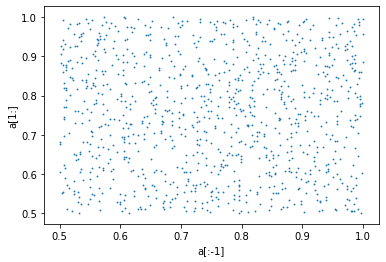

In [15]:
plt.scatter(a[:-1], a[1:], s=0.7)
plt.xlabel('a[:-1]')
plt.ylabel('a[1:]')
plt.show()

-------------------
#### d)
$g_{n}(x)$라는 함수를 다음과 같이 정의하고,
$$
g_{n}(x)=\frac{\Gamma(\frac{n+1}{2})}{(n\pi)^{1/2}\Gamma(\frac{n}{2})}(1+\frac{x^{2}}{n})^{-(n+1)/2}, \quad \textrm{for} \quad -5 < x < 5, \quad n=1,2,3,4,...
$$
$g_{n}(x)$가 n이 커짐에 따라 어떤 형태를 갖게되는지 알아보고자 한다. n = 1,2,...,30에 따른 gn(x)의 그래프와 f(x)의 그래프를 함께 그려보고, 그 결과를 설명하시오. 

* 주어진 문제의 $f(x)$, $g_{n}(x)$ 함수를 정의하시오. : f, gn

In [16]:
def f(x) :
    return math.exp(-x**2 / 2)/math.sqrt(2*math.pi)

def gn(x, n) :
    return math.gamma((n+1)/2)/((n*math.pi)**(0.5)*math.gamma(n/2))*\
           (1+x**2/n)**(-(n+1)/2)

* $-5<x<5$사이의 값에서 $g_{n}(x)$를 n에 따라 f(x)와 같이 그리세요.
    - 6*5 subplot 생성 (총 30개 plot)
    - 각 subplot 별로 다음과 같이 plot을 형성하시오.
        - scatter of fx : s=0.4, alpha=0.5
        - scatter of gx : s=0.4, alpha=0.5, c='tomato'
        - title : g(x, n) vs. f(x) (n은 각 plot별로 사용된 n.)  
            ex) for n = 1, "g(x, 1) vs. f(x)'
        - legend : markerscale=10, fontsize=12,  
            label : $f(x), \textrm{ } g(x, n)$  

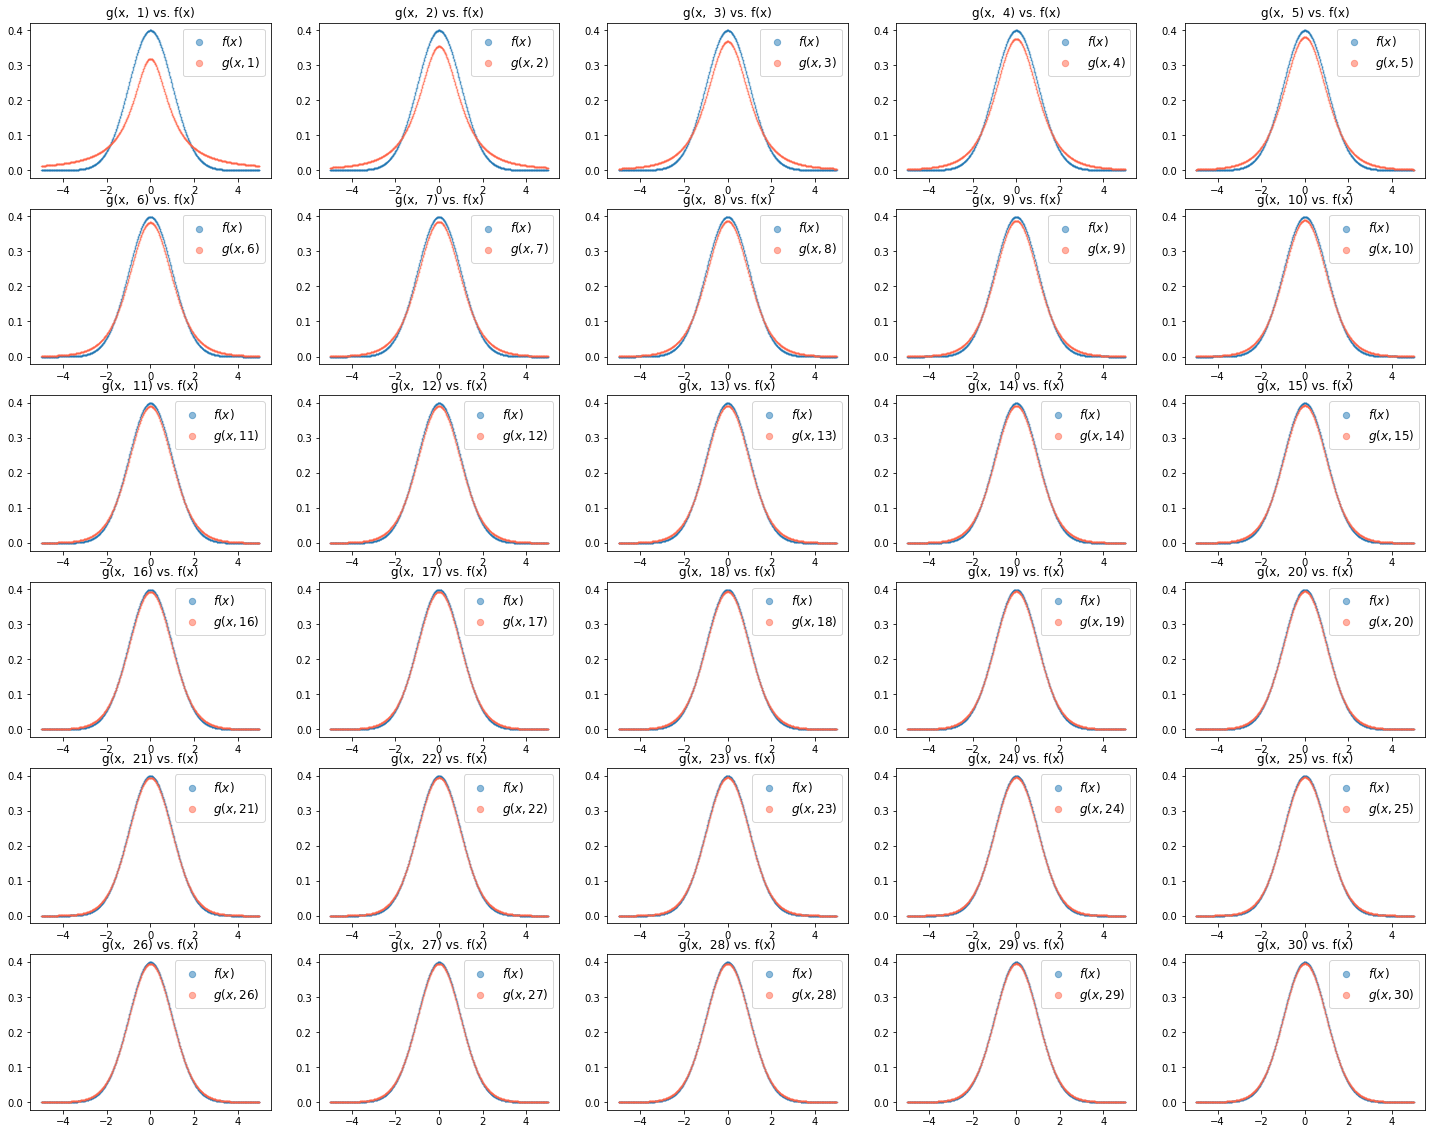

In [17]:
# set x, with length 1000
x = np.linspace(-5, 5, 1000)

# plt rcParams Setting
fig_default = plt.rcParams.get('figure.figsize')
plt.rcParams['figure.figsize'] = [25, 20]

fig = plt.figure()

for n in range(1, 31):
    ax = fig.add_subplot(6, 5, n)
    fx = [f(i) for i in x]
    gx = [gn(i, n) for i in x]
    ax.scatter(x, fx, s=0.4, alpha=0.5)
    ax.scatter(x, gx, s=0.4, alpha=0.5, c='tomato')
    plt.title("g(x, {0: 2d}) vs. f(x)".format(n))
    plt.legend(['$f(x)$', '$g(x, {0: 2d})$'.format(n)], markerscale=10, fontsize=12)

plt.show()

위의 plot은 n이 1부터 30까지의 $g_{x}(x)$와 $f(x)$를 같이 나태낸 것이다. n이 커질수록 $g_{n}(x)$가 $f(x)$에 근사함을 알 수 있다.
* $g_{n}(x)$은 사실 t(n)분포이다.

-------------
#### e)
 n이 증가함에 따라(n = 1,2,...,1000), $\Gamma(\frac{n+1}{2})$와 $\sqrt{2\pi (n-1)/2} [(n-1)/(2e)]^{(n-1)/2}$의 비율이 1로 수렴하는지 확인하고,  $\sqrt{2\pi (n-1)/2} [(n-1)/(2e)]^{(n-1)/2}$가 벤포드의 법칙을 따르는지 확인하시오.

In [18]:
def log_f1(n):
    return math.lgamma((n+1)/2)
def log_f2(n):
    if n == 1:
        return 0
    return math.log(2*math.pi*(n-1)/2)/2+\
           ((n-1)/2)*math.log((n-1)/(2*math.exp(1)))

In [19]:
# calculate ratio of two mathmatic statement
log_ratio = np.array([log_f1(n) - log_f2(n) for n in range(1, 1001)])

# print first 5 entries of log_ratio
print(log_ratio[:5])

[0.         0.15342641 0.08106147 0.05481412 0.0413407 ]


* 두 수식이 n이 증가함에 따라 비율이 1로 수렴하는지 시각적으로 보이시오.

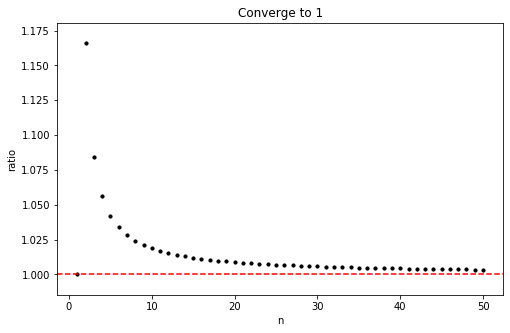

In [20]:
ratio = np.exp(log_ratio)
plt.rcParams['figure.figsize'] = [8, 5]

plt.scatter(range(1, 51), ratio[:50], s=10, color='black')
plt.xlabel("n")
plt.ylabel("ratio")
plt.axhline(1, linestyle='--', color='red')
plt.title('Converge to 1')
plt.show()

위의 plot을 보면 두 수식의 비율이 1에 수렴함을 알 수 있다.

* $\sqrt{2\pi (n-1)/2} [(n-1)/(2e)]^{(n-1)/2}$가 벤포드의 법칙을 따르는지 확인하시오.  
아래의 설명은 최태련 교수님의 STAT323 Chapter 2 강의안에 있습니다.
* 벤포드의 법칙은 자연고학의 법칙과 같이 항상 성립하는 법칙이 아니라 상당수의 자료에서 성립하는 경향이 있다는 것을 의미한다.
* 벤포드의 법칙은 기업의 회계부정이나 가격 담합 등을 적발하는데 이용된다.
* 어떤 숫자의 집합이 벤포드의 법칙을 따른다면, 첫번째 숫자 D의 확률분포는 다음과 같다.
$$P(D=k)=\log_{10}(k+1)-\log_{10}(k), \quad k=1,2,...,9$$
    - 만약 어떤 숫자가 120398054809810라면, D는 1이다.

* Benford 확률분포를 담은 array를 만드세요 : benford

In [21]:
benford = np.array([math.log10(k+1)-math.log10(k) for k in range(1, 10)])

# print probability distribution of benford
benford

array([0.30103   , 0.17609126, 0.12493874, 0.09691001, 0.07918125,
       0.06694679, 0.05799195, 0.05115252, 0.04575749])

* 한 가지 문제가 있을 겁니다.

In [22]:
# print math.exp(log_f2(500))
print(math.exp(log_f2(500)))

OverflowError: math range error

* OverflowError를 일으키기 전까지만 사용합시다.
    - 파이썬이 인식하는 가장 큰 수보다 작은 값만 저장합시다.

In [23]:
# import sys
import sys

# print sys.float_info.max
print(sys.float_info.max)

# generate empty list : f2s
f2s = []

# in for loop, using try and except statement to ignore OverflowError.
for n in range(1, 1001):
    log_f2s = log_f2(n)
    try :
        if math.exp(log_f2s) < sys.float_info.max:
            f2s.append(math.exp(log_f2s))
    except OverflowError :
        break
        
print(len(f2s))

1.7976931348623157e+308
342


* 위에서 생성된 f2의 첫번째 숫자인 D를 추출한 Series를 생성하세요 : Ds

In [24]:
Ds = pd.Series([f // 10**math.floor(math.log10(f)) for f in f2s]).astype(int)

# print head of Ds
print(Ds.head())

0    1
1    7
2    9
3    1
4    1
dtype: int32


* Get Empirical probability distribution of Ds
    - please sort index

In [25]:
Ds.value_counts(normalize=True).sort_index()

1    0.342105
2    0.157895
3    0.128655
4    0.067251
5    0.084795
6    0.046784
7    0.038012
8    0.061404
9    0.073099
dtype: float64

* compare with benford by using DataFrame.

In [26]:
zips = zip(benford, Ds.value_counts(normalize=True).sort_index())
df = pd.DataFrame(zips, columns=['Benford', 'Ds'], index = range(1, 10))

# display DataFrame
display(df)

,Benford,Ds
1,0.301030,0.342105
2,0.176091,0.157895
3,0.124939,0.128655
4,0.096910,0.067251
5,0.079181,0.084795
6,0.066947,0.046784
7,0.057992,0.038012
8,0.051153,0.061404
9,0.045757,0.073099


위의 df를 보면 Ds가 Benford 법칙을 따르지 않음을 알 수 있다.

* Benford, Ds의 bar plot을 한 plot에 겹쳐서 보여주세요.
    - benford : alpha = 0.5
    - Ds : alpha = 0.5, color = 'tomato'
    - xlabel : 'D'
    - ylabel : 'probability'
    - title : 'Benford vs. Ds'
    - legned : 'Benford distribution', 'D's distribution'

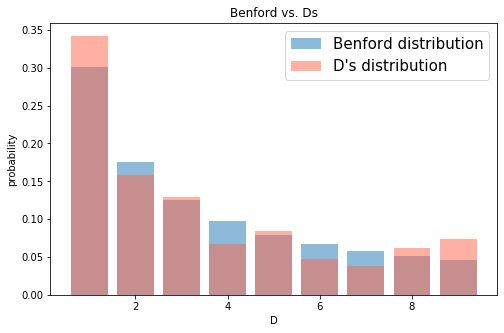

In [27]:
plt.bar(df.index, df.Benford, alpha=0.5)
plt.bar(df.index, df.Ds, alpha=0.5, color = 'tomato')
plt.xlabel('D')
plt.ylabel('probability')
plt.title('Benford vs. Ds')
plt.legend(['Benford distribution', "D's distribution"], fontsize=15)
plt.show()

Benford 법칙을 따르지 않음을 더욱 잘 보일 수 있다.

--------------------------
--------------------------
### 2. Polynomial regression

n개의 자료 ($x_{1}$, $y_{1}$), ($x_{2}$, $y_{2}$), ..., ($x_{n}$, $y_{n}$)이 주어졌을 때, 다음과 같은 $m(<n)$차 다항식 회귀 모형을 고려하자.
$$y_{i} = \beta_{0}+\beta_{1}x_{i}+\beta_{2}x_{i}^{2}+\cdots+\beta_{n}x_{i}^{n}+\epsilon_{i}, \quad i=1,...,n$$  
이러한 모형을 벡터와 행렬을 사용하여 나타내면 다음과 같다.  

$$\mathbf{y=X\beta+\epsilon},\textrm{ }\mathbf{y}=(y_{1},...,y_{n})^{T}, \textrm{ }\mathbf{\beta}=(\beta_{1},...,\beta_{n})^{T}, \textrm{ }\mathbf{\epsilon}=(\epsilon_{1},...,\epsilon_{n})^{T}$$
$$\mathbf{X}=(\mathbf{x_{1}},...,\mathbf{x_{n})}^{T},\textrm{ }\mathbf{x_{i}}=(1, x_{i},x_{i}^{2},...,x_{i}^{m})^{T}$$

#### a)
x가 {1/100, 2/100, ..., 100/100}까지의 100개의 값을 갖는 변수라고 할 때, x의 다항식을 설명변수로 하는 다음과 같은 4(m=4)차 다항식 회귀모형을 고려하고, 대응하는 100개의 y값을 생성하시오.  

$$y_{i} = 1+2x_{i}-3x_{i}^{2}+4x_{i}^{3}-5x_{i}^{4}+\epsilon_{i}, \quad \epsilon_{i}\sim N(0, 0.1^{2})$$
$$  $$
(오차항을 생성하기 위해서 np.random.normal()함수 사용 가능)

In [28]:
# import math, numpy, pandas, matplotlib.pyplot
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# gerate x array
x = np.linspace(0.01, 1, 100)

# generate y
y = 1+2*x-3*x**2+4*x**3-5*x**4 + np.random.normal(0, 0.1, len(x))

# print first five entries of x and y
print(pd.DataFrame(zip(x,y), columns=['x','y']).head())

      x         y
0  0.01  1.136405
1  0.02  1.027318
2  0.03  1.120718
3  0.04  1.037294
4  0.05  1.165610


--------------
#### b)
(a)에서 생성된 x와 y를 바탕으로 행렬 $X$와 $y$를 만들고, 이를 바탕으로 $\beta$의 추정치 $\hat{\beta}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{Y}$를 계산하고, 참 값 $\beta_{0}=(1, 2, -3, 4, -5)^{T}$와 비교하시오.  
(역행렬을 계산하기 위해서 numpy.linalg.inv 함수 사용 가능)

In [30]:
# make X matrix
X = np.array(pd.DataFrame(zip([1]*100, x, x**2, x**3, x**4)))

# print first five entries of X
print(X[:5])

# Calculate beta hat
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

print("""%25sBeta_hat vs Real Coefficients
%10s %10s %10s %10s %10s %10s
%10s %10f %10f %10f %10f %10f
%10s %10d %10d %10d %10d %10d
"""\
      % tuple(["","", 'Intercept', 'x', 'x^2', 'x^3', 'x^4', "Estimated"]\
              +list(np.round(beta_hat, 4))+["Real value"]+[1, 2, -3, 4, -5]))

[[1.00e+00 1.00e-02 1.00e-04 1.00e-06 1.00e-08]
 [1.00e+00 2.00e-02 4.00e-04 8.00e-06 1.60e-07]
 [1.00e+00 3.00e-02 9.00e-04 2.70e-05 8.10e-07]
 [1.00e+00 4.00e-02 1.60e-03 6.40e-05 2.56e-06]
 [1.00e+00 5.00e-02 2.50e-03 1.25e-04 6.25e-06]]
                         Beta_hat vs Real Coefficients
            Intercept          x        x^2        x^3        x^4
 Estimated   1.054500   1.499800  -1.525900   2.275400  -4.331700
Real value          1          2         -3          4         -5



* compare beta_hat with np.linalg.lstsq(X, y, rcond=-1)
    - lstsq는 Least square method를 활용하며, Ax=b에서의 x, 잔차제곱합(residual sum of squares), 랭크(rank), 특잇값(singular value)을 반환한다.

In [31]:
beta = np.linalg.lstsq(X, y, rcond=-1)[0]
print("""%25sBeta_hat vs Real Coefficients
%10s %10s %10s %10s %10s %10s
%10s %10f %10f %10f %10f %10f
%10s %10f %10f %10f %10f %10f
%10s %10d %10d %10d %10d %10d
"""\
      % tuple(["","", 'Intercept', 'x', 'x^2', 'x^3', 'x^4', "Estimated"]\
              +list(np.round(beta_hat, 4))+['Built-in']+list(beta)\
              +["Real value", 1, 2, -3, 4, -5]))

                         Beta_hat vs Real Coefficients
            Intercept          x        x^2        x^3        x^4
 Estimated   1.054500   1.499800  -1.525900   2.275400  -4.331700
  Built-in   1.054460   1.499795  -1.525913   2.275364  -4.331725
Real value          1          2         -3          4         -5



* beta_hat을 통해 도출한 y값들과 linalg.lstsq를 활용하여 도출한 y값들을 서로 시각적으로 비교하시오.
    - plot에 predicted y는 line으로 그리고, 실제 y값은 scatter plot로 그리세요.

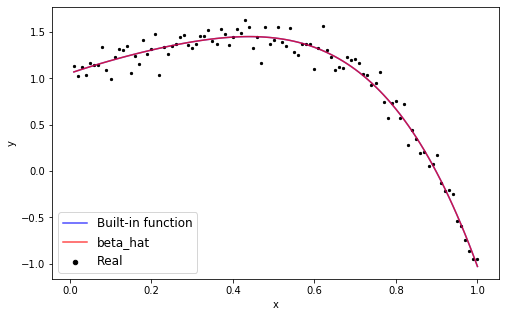

In [32]:
y1 = X @ beta_hat
y2 = X @ beta

plt.plot(x, y1, alpha=0.7, color='blue')
plt.plot(x, y2, alpha=0.7, color='red')
plt.scatter(x, y, color='black', s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower left', labels=['Built-in function', 'beta_hat', 'Real'], fontsize=12, markerscale=2)
plt.show()

--------------------
#### c)
행렬 $\mathbf{A}=\mathbf{I_{100}}-\mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}$로 정의하자. $\mathbf{A}^{10}$의 고윳값을 계산하시오.  
고윳값에 허수가 있는지 확인하시오.  
(Python 내장함수 numpy.linalg.identity, numpy.linalg.matrix_power, numpy.linalg.eig)

In [33]:
A = np.identity(100) - X @ np.linalg.inv(X.T @ X) @ X.T
A_10 = np.linalg.matrix_power(A, 10)

# print last 5 entries of eigen values of A_10
print(np.linalg.eig(A_10)[0][-5:])

[1.+0.00000000e+00j 1.+4.64439613e-16j 1.-4.64439613e-16j
 1.+0.00000000e+00j 1.+0.00000000e+00j]


허수인 eigen value가 나오는 것을 확인할 수 있다.  
또한, eigen value에 허수가 있어 eigen value 끼리의 크기를 비교할 수 없기 때문에 A이 10제곱은 power method 방법으로 고윳값을 계산할 수 없다.

---------------------
#### d)
200개의 자료 {($x_{1}$, $y_{1}$), ($x_{2}$, $y_{2}$), ..., ($x_{200}$, $y_{200}$)} 가 다음과 같은 모형에서 생성되었다고 가정하자.  

$$y_{i}=f(x_{i})+\epsilon_{i},\quad i=1,...,200$$  
$$f(x_{i})=1000[0.3x_{i}^{2}(1-x_{i})^{6}+0.7x_{i}^{6}(1-x_{i})^{2}]+\epsilon_{i},\textrm{ }\epsilon_{i}\sim N(0,1), x_{i}=(i-1/2)/200$$
이 경우, 다항식 회귀 모형 대신에 다음과 같은 (cosine) 회귀모형으로 적합하고자 한다. 

$$f_{k}(x)=\beta_{0}+\sum^{4}_{j=1}\beta_{j}cos(\pi jx)$$  
$\mathbf{\beta}$의 추정치 $\hat{\beta}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{Y}$를 계산하고, 적합된 cosine 회귀함수와 실제 함수 $f(x)$를 비교해보시오.

In [34]:
# generate appropriate x and y
x = (np.linspace(1, 200, 200)-0.5)/200
y = np.array([float(1000*(0.3*i**2*(1-i)**6+0.7*i**6*(1-i)**2)+np.random.normal(0,1,1)) for i in x])

# print first 5 entries of y
print(y[:5])

[-0.02587725  1.53586657 -1.87305734 -0.30728612 -0.7595355 ]


In [35]:
# Make X matrix
cols = [[1]*200]
for i in range(4):
    cols.append([math.cos(k*math.pi*(i+1)) for k in x])
    
X = np.array(pd.DataFrame(zip(cols[0], cols[1], cols[2], cols[3], cols[4])))

# print fist 5 entries of X
print(X[:5])

[[1.         0.99996916 0.99987663 0.99972243 0.99950656]
 [1.         0.99972243 0.99888987 0.9975028  0.99556196]
 [1.         0.99922904 0.99691733 0.99306846 0.98768834]
 [1.         0.9984891  0.99396096 0.98642926 0.97591676]
 [1.         0.9975028  0.99002366 0.97759994 0.96029369]]


In [36]:
# Calculate beta_hat
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

print("""%25sBeta_hat Coefficients
%10s %10s %10s %10s %10s %10s
%10s %10f %10f %10f %10f %10f
"""\
      % tuple(["","", 'Intercept', 'x', 'x^2', 'x^3', 'x^4', "Estimated"]\
              +list(np.round(beta_hat, 4))))

                         Beta_hat Coefficients
            Intercept          x        x^2        x^3        x^4
 Estimated   3.790000  -1.716300  -1.315900   1.042000  -1.564700



* beta_hat을 따르는 Fitted line과 실제 수식을 따르는 Real Line과 그리세요.
    - plot에 실제 y는 scatter plot으로 나타내세요.

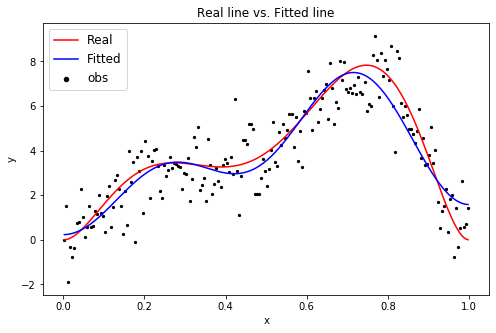

In [37]:
y1 = X @ beta_hat
y2 = np.array([float(1000*(0.3*i**2*(1-i)**6+0.7*i**6*(1-i)**2)) for i in x])

plt.plot(x, y2, c='Red')
plt.plot(x, y1, c='Blue')
plt.scatter(x,y, s=5, c='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Real line vs. Fitted line')
plt.legend(loc='upper left', labels=['Real', 'Fitted', 'obs'], markerscale=2, fontsize=12)
plt.show()

### END